In [8]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from PIL import Image
from pathlib import Path

# import tensorflow as tf
from matplotlib import pyplot as plt
import cv2
from object_detection.utils import ops as utils_ops
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

%matplotlib inline

sys.path.append("..")

Instructions for updating:
non-resource variables are not supported in the long term


In [60]:
MODEL_NAME = 'clothes_detection'
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'
PATH_TO_LABELS = 'labelmap.pbtxt'

PATH_TO_TEST_IMAGES_DIR = 'test_img'
PATH_TO_IMAGES_DIR = 'img/img'
PATH_TO_CUTTED_IMAGES = 'cut_img'
FEATURES_DIR = 'features'

TEST_IMAGE_PATHS = os.listdir(PATH_TO_TEST_IMAGES_DIR)
IMAGE_SIZE = (12, 8)

IMAGE_PATHS = list(map(lambda x: PATH_TO_IMAGES_DIR + '/' + x, os.listdir(PATH_TO_IMAGES_DIR)))
backup_last_index_file_name = 'backup.txt'
backup_last_index_path = PATH_TO_CUTTED_IMAGES + '/' + backup_last_index_file_name
last_index = 0
# print(IMAGE_PATHS[0])
# print(len(IMAGE_PATHS))

In [61]:
def box2cords(box, width, height):
    ymin = int(box[0]*height)
    xmin = int(box[1]*width)
    ymax = int(box[2]*height)
    xmax = int(box[3]*width)
    return ymin, xmin, ymax, xmax

In [62]:
def load_image_into_numpy_array(image):
    im_width, im_height = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

In [63]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [13]:
def quantify_colors(img, k=32, attempts=5):
    """
    :param img: An array of N-Dimensional points with int coordinates is needed.
    :param k: int
    :param attempts: int
    """
    float_pixels = np.float32(img)
    float_pixels = float_pixels.reshape((float_pixels.shape[0] * float_pixels.shape[1], 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    ret, label, center = cv2.kmeans(float_pixels, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
    # Now convert back into uint8, and make original image
    center = np.uint8(center)
    ret = center[label.flatten()]
    ret = ret.reshape(img.shape)
    return ret

def plot_colors(data):
    """
    :param data: (cluster names, cluster colors, cluster histogram)
    :return:
    """
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    start_x = 0

    # loop over the percentage of each cluster and the color of
    # each cluster
    for (_, color, percent) in data:
        # plot the relative percentage of each cluster
        end_x = start_x + (percent * 300)
        cv2.rectangle(bar, (int(start_x), 0), (int(end_x), 50),
                      color.astype("uint8").tolist(), -1)
        start_x = end_x

    # return the bar chart
    return bar

def distance_sq(left, right):
    """ Returns the square of the distance between left and right. """
    return (
            ((int(left[0]) - int(right[0])) ** 2) +
            ((int(left[1]) - int(right[1])) ** 2) +
            ((int(left[2]) - int(right[2])) ** 2)
    )

def distance(left, right):
    """ Returns the distance between left and right. """
    return (((int(left[0]) - int(right[0])) ** 2) +
            ((int(left[1]) - int(right[1])) ** 2) +
            ((int(left[2]) - int(right[2])) ** 2)
            ) ** .5

def print_progress(iteration, total, prefix='', suffix='', decimals=1, bar_length=100):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        bar_length  - Optional  : character length of bar (Int)
    """
    str_format = "{0:." + str(decimals) + "f}"
    percents = str_format.format(100 * (iteration / float(total)))
    filled_length = int(round(bar_length * iteration / float(total)))
    bar = '█' * filled_length + '-' * (bar_length - filled_length)

    sys.stdout.write('\r%s |%s| %s%s %s' % (prefix, bar, percents, '%', suffix)),

    if iteration == total:
        sys.stdout.write('\n')
    sys.stdout.flush()

def new_image_size(orig_width, orig_height, smallest_side_size):
    new_w = orig_width
    new_h = orig_height
    if smallest_side_size <= 0:
        return new_w, new_h

    if orig_width > orig_height:
        new_h = smallest_side_size
        new_w = round(orig_width * new_h / orig_height)
    else:
        new_w = smallest_side_size
        new_h = round(orig_height * new_w / orig_width)

    return new_w, new_h

In [14]:
def rembg(path):
    smallestSideSize = 500
    # real would be thicker because of masking process
    mainRectSize = .04
    fgSize = .15

    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    height, width = img.shape[:2]
    new_w, new_h = new_image_size(width, height, smallestSideSize)

    # resize image to lower resources usage
    # if you need masked image in original size, do not resize it
    img_small = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # quantify colors
    img_small = quantify_colors(img_small, 32, 10)

    # create mask tpl
    mask = np.zeros(img_small.shape[:2], np.uint8)

    # create BG rect
    bg_w = round(new_w * mainRectSize)
    bg_h = round(new_h * mainRectSize)
    bg_rect = (bg_w, bg_h, new_w - bg_w, new_h - bg_h)

    # create FG rect
    fg_w = round(new_w * (1 - fgSize) / 2)
    fg_h = round(new_h * (1 - fgSize) / 2)
    fg_rect = (fg_w, fg_h, new_w - fg_w, new_h - fg_h)

    bgdModel1 = np.zeros((1, 65), np.float64)
    fgdModel1 = np.zeros((1, 65), np.float64)

    cv2.grabCut(img_small, mask, bg_rect, bgdModel1, fgdModel1, 3, cv2.GC_INIT_WITH_RECT)
    mask_rect = mask.copy()

#     cv2.rectangle(mask, bg_rect[:2], bg_rect[2:4], color=cv2.GC_PR_BGD, thickness=bg_w * 3)
    cv2.grabCut(img_small, mask, bg_rect, bgdModel1, fgdModel1, 10, cv2.GC_INIT_WITH_MASK)
#     mask_mask = mask.copy()

    # mask to remove background
    mask_result = np.where((mask == 1) + (mask == 3), 255, 0).astype('uint8')

    # if we are removing too much, assume there is no background
    unique, counts = np.unique(mask_result, return_counts=True)
    mask_dict = dict(zip(unique, counts))

    if mask_dict[0] > mask_dict[255] * 1.6:
        mask_result = np.where((mask == 0) + (mask != 1) + (mask != 3), 255, 0).astype('uint8')

    # apply mask to image
    masked = cv2.bitwise_and(img_small, img_small, mask=mask_result)
    masked[mask_result < 2] = [255, 255, 255]  # change black bg to blue
    
    return masked

In [15]:
 def tf_tuning():
    detection_graph = tf.Graph()
    with detection_graph.as_default():
        od_graph_def = tf.GraphDef()
        with tf.io.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
            serialized_graph = fid.read()
            od_graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(od_graph_def, name='')
    return detection_graph

In [16]:
def cut_images(
    category_index,
    backup_last_index_path,
    IMAGE_PATHS,
    PATH_TO_CUTTED_IMAGES,
    last_index,
    detection_graph
):
    if not os.path.exists(PATH_TO_CUTTED_IMAGES):
        os.mkdir(PATH_TO_CUTTED_IMAGES)
    
    print(category_index, '\n')
    if not os.path.exists(backup_last_index_path):
        backup_file = open(backup_last_index_path, "w")
        backup_file.write('0')
        backup_file.close()
    else:
        backup_file = open(backup_last_index_path, "r")
        last_index = int(backup_file.readline()) + 1
        backup_file.close()

    print('last_index = ', last_index, '\n')    

    for i, img_path in enumerate(sorted(IMAGE_PATHS[last_index:401])):
        image = load_image_into_numpy_array(Image.open(img_path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_rembg = rembg(img_path)
        cv2.resize(image, (image_rembg.shape[0], image_rembg.shape[1]), interpolation = cv2.INTER_AREA)
        image_rembg_expanded = np.expand_dims(image_rembg, axis=0)
        output_dict = run_inference_for_single_image(image_rembg, detection_graph)
        index_of_max_score = np.where(output_dict['detection_scores'] == max(output_dict['detection_scores']))
        box_with_max_score = output_dict['detection_boxes'][index_of_max_score][0]
    #     print('box_with_max_score', box_with_max_score)
        ymin, xmin, ymax, xmax = box2cords(box_with_max_score, image.shape[1], image.shape[0])
        image_cutted = image[ymin:ymax, xmin:xmax]
        class_path = category_index[output_dict['detection_classes'][index_of_max_score][0]]['name']
    #     print('class_path', class_path)

        path_to_folder = PATH_TO_CUTTED_IMAGES + '/' + str(class_path) 
    #     print(path_to_folder)
        if not os.path.exists(path_to_folder):
            os.mkdir(path_to_folder)
        path_to_image = path_to_folder + '/' + img_path.split('/')[-1]
    #     cv2.imshow('asdas', image_cutted)
    #     cv2.waitKey(0)
        print(last_index + i, path_to_image)
        # backup last index
        backup_file = open(backup_last_index_path, "w")
        backup_file.write(str(last_index + i))
        backup_file.close()

        cv2.imwrite(path_to_image, image_cutted)

In [64]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
detection_graph = tf_tuning()

In [ ]:
cut_images(category_index, backup_last_index_path, IMAGE_PATHS, PATH_TO_CUTTED_IMAGES, last_index, detection_graph)

# Визуальный поиск

In [17]:
class FeatureExtractor:
    def __init__(self):
        # Use VGG-16 as the architecture and ImageNet for the weight
        base_model = VGG16(weights='imagenet')
        # Customize the model to return features from fully-connected layer
        self.model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc1').output)
    def extract(self, img):
        # Resize the image
        img = img.resize((224, 224))
        # Convert the image color space
        img = img.convert('RGB')
        # Reformat the image
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        # Extract Features
        feature = self.model.predict(x)[0]
        return feature / np.linalg.norm(feature)

In [18]:
def extract_features_from_classes(
    PATH_TO_CUTTED_IMAGES,
    backup_last_index_file_name,
    FEATURES_DIR,
    fe
):    
    cut_dirs_classes = os.listdir(PATH_TO_CUTTED_IMAGES)
    cut_dirs_classes.remove(backup_last_index_file_name)

    if not os.path.exists(FEATURES_DIR):
        os.mkdir(FEATURES_DIR)

    for folder in cut_dirs_classes:
        path_to_folder =  PATH_TO_CUTTED_IMAGES + '/' + folder

        for img_path in sorted(os.listdir(path_to_folder)):
            full_img_path = path_to_folder + '/' + img_path
            feature = fe.extract(img=Image.open(full_img_path))
            feature_dir = FEATURES_DIR + '/' + folder
            feature_path = feature_dir + '/' + img_path.split('.')[0] + ".npy"
            if not os.path.exists(feature_dir):
                os.mkdir(feature_dir)
            np.save(feature_path, feature)
        print(folder + ' done')

In [43]:
def get_all_saved_features(FEATURES_DIR):
    features = []
    cut_dirs_classes = os.listdir(FEATURES_DIR)
    for cut_dirs_class in cut_dirs_classes:
        for feature_path in Path("./" + FEATURES_DIR + '/' + cut_dirs_class).glob("*.npy"):
            features.append(np.load(feature_path))

    features = np.array(features)

    return features

In [68]:
def get_all_saved_features_by_classes(FEATURES_DIR):
    features = {}
    cut_dirs_classes = os.listdir(FEATURES_DIR)
    for cut_dirs_class in cut_dirs_classes:
        for feature_path in Path("./" + FEATURES_DIR + '/' + cut_dirs_class).glob("*.npy"):
            if cut_dirs_class in features.keys():
#                 features[cut_dirs_class] = np.append(features[cut_dirs_class], np.array(np.load(feature_path)))
#             else:
#                 features[cut_dirs_class] = np.array(np.load(feature_path))
                features[cut_dirs_class].append(np.load(feature_path))
            else:
                features[cut_dirs_class] = [np.load(feature_path)]

    for feature_class in features.keys():
        features[feature_class] = np.array(features[feature_class])
#     features = np.array(features)
    return features

In [69]:
def get_cut_img_paths(PATH_TO_CUTTED_IMAGES):
    cut_img_paths_arr = []
    cut_dirs_classes = os.listdir(PATH_TO_CUTTED_IMAGES)
    cut_dirs_classes.remove(backup_last_index_file_name)
    
    for cut_dirs_class in cut_dirs_classes:
        img_paths_of_class_wrong_format = list(Path("./" + PATH_TO_CUTTED_IMAGES + '/' + cut_dirs_class).glob("*.*"))
        img_paths_of_class = list(map(lambda x: str(x), img_paths_of_class_wrong_format))
        cut_img_paths_arr.extend(img_paths_of_class)

    return cut_img_paths_arr

In [70]:
def find_class_and_cut_img(img_path, detection_graph):
    image = load_image_into_numpy_array(Image.open(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_rembg = rembg(img_path)
    cv2.resize(image, (image_rembg.shape[0], image_rembg.shape[1]), interpolation = cv2.INTER_AREA)
    image_rembg_expanded = np.expand_dims(image_rembg, axis=0)
    output_dict = run_inference_for_single_image(image_rembg, detection_graph)
    index_of_max_score = np.where(output_dict['detection_scores'] == max(output_dict['detection_scores']))
    class_path = category_index[output_dict['detection_classes'][index_of_max_score][0]]['name']
    
    box_with_max_score = output_dict['detection_boxes'][index_of_max_score][0]
#     print('box_with_max_score', box_with_max_score)
    ymin, xmin, ymax, xmax = box2cords(box_with_max_score, image.shape[1], image.shape[0])
    image_cutted = image[ymin:ymax, xmin:xmax]
    
    return class_path, image_cutted

In [83]:
def find_similar_img(img, img_class, img_paths, features, fe, count_of_similar):
    # Extract its features
    query = fe.extract(img)
    # Calculate the similarity (distance) between images
    dists = np.linalg.norm(features - query, axis=1)
    # Extract 30 images that have lowest distance
    ids = np.argsort(dists)[:count_of_similar]
#     print(len(dists), len(img_paths))
#     print(img_paths)
    similar_img_names = [img_paths[id].split('\\')[-1] for id in ids]
    scores = [(dists[id], img_paths[id]) for id in ids]
#     print(scores)
    # Visualize the result
    axes=[]
    fig=plt.figure(figsize=(8,8))
    for a in range(count_of_similar):
        score = scores[a]
        axes.append(fig.add_subplot(5, 6, a+1))
        subplot_title=str(score[0])
        axes[-1].set_title(subplot_title)  
        plt.axis('off')
        plt.imshow(Image.open(score[1]))
    fig.tight_layout()
    plt.show()
    
    return similar_img_names

In [72]:
def add_img_to_db(img, img_name, detection_graph, PATH_TO_IMAGES_DIR, fe):
    full_img_path = PATH_TO_IMAGES_DIR + '/' + img_name
    cv2.imwrite(full_img_path, img)
    
    img_class, cutted_img_arr = find_class_and_cut_img(img, detection_graph)

    feature = fe.extract(img=Image.open(full_img_path))
    feature_dir = FEATURES_DIR + '/' + img_class
    feature_path = feature_dir + '/' + img_name.split('.')[0] + ".npy"
    if not os.path.exists(feature_dir):
        os.mkdir(feature_dir)
    np.save(feature_path, feature)
    print(folder + ' done')

In [25]:
fe = FeatureExtractor()

In [26]:
extract_features_from_classes(PATH_TO_CUTTED_IMAGES, backup_last_index_file_name, FEATURES_DIR, fe)

In [81]:
detection_graph = tf_tuning()
# features = get_all_saved_features(FEATURES_DIR)
features = get_all_saved_features_by_classes(FEATURES_DIR)
cut_img_paths = get_cut_img_paths(PATH_TO_CUTTED_IMAGES)

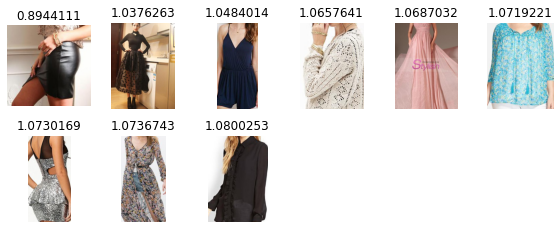

['img_00000088.jpg',
 'img_00000047.jpg',
 'img_00000254.jpg',
 'img_00000211.jpg',
 'img_00000199.jpg',
 'img_00000081.jpg',
 'img_00000057.jpg',
 'img_00000201.jpg',
 'img_00000082.jpg']

In [85]:
image_path = r"img/img/img_00000015.jpg"
img = Image.open(image_path)
img_class, cutted_img_arr = find_class_and_cut_img(image_path, detection_graph)
features_of_class = features[img_class]
cutted_img = Image.fromarray(np.uint8(cutted_img_arr)).convert('RGB')
# find_similar_img(cutted_img, img_class, cut_img_paths, features, fe, 9)
find_similar_img(cutted_img, img_class, cut_img_paths, features_of_class, fe, 9)